# Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import PIL
import pathlib

# Loading the `Dataset`

In [ ]:
# Loading the data from Google Drive
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1WMX6Y1xp4pR-lImE3JaxMxswzge3Keu_
!unzip BigWildfireDataset.zip
!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rSmTXTH8qaYIpXB_NzBXPLlDrNi46OFs
To: /content/BigWildfireDataset.zip
100% 337M/337M [00:05<00:00, 61.2MB/s]
Archive:  BigWildfireDataset.zip
   creating: BigWildfireDataset/test/
  inflating: BigWildfireDataset/test/fire (1).jpg  
  inflating: BigWildfireDataset/test/fire (10).jpg  
  inflating: BigWildfireDataset/test/fire (100).jpg  
  inflating: BigWildfireDataset/test/fire (101).jpg  
  inflating: BigWildfireDataset/test/fire (102).jpg  
  inflating: BigWildfireDataset/test/fi

In [ ]:
# Checking the classes 
!ls BigWildfireDataset

test  train


# Filtering out corrupted images

In [ ]:
import os

num_skipped = 0
for folder_name in ("fire", "safe","smoke"):
    folder_path = os.path.join("/content/BigWildfireDataset/train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 12 images


# Generating the `Dataset`

In [ ]:
image_size = (320, 320)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/BigWildfireDataset/train",
    validation_split=0.3,
    subset="training",
    seed=13,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/BigWildfireDataset/train",
    validation_split=0.3,
    subset="validation",
    seed=13,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2700 files belonging to 3 classes.
Using 1890 files for training.
Found 2700 files belonging to 3 classes.
Using 810 files for validation.


## Visualizing the `Dataset`

['fire', 'safe', 'smoke']


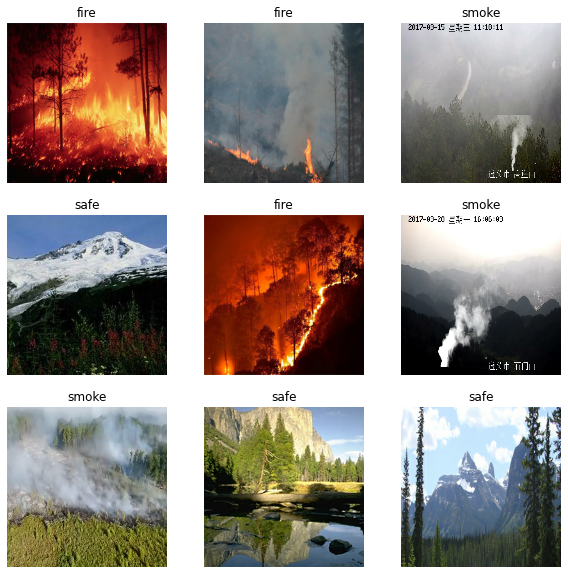

In [ ]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title((class_names[labels[i]]))
        plt.axis("off")

# `Dataset` Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

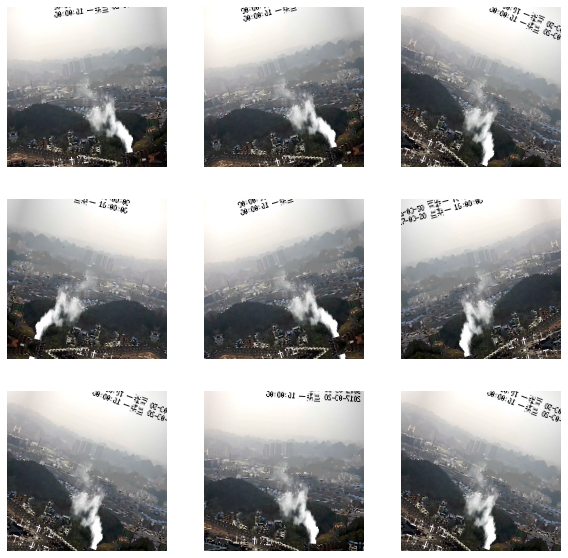

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Configuring the `Dataset` for Performance

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Building the Model

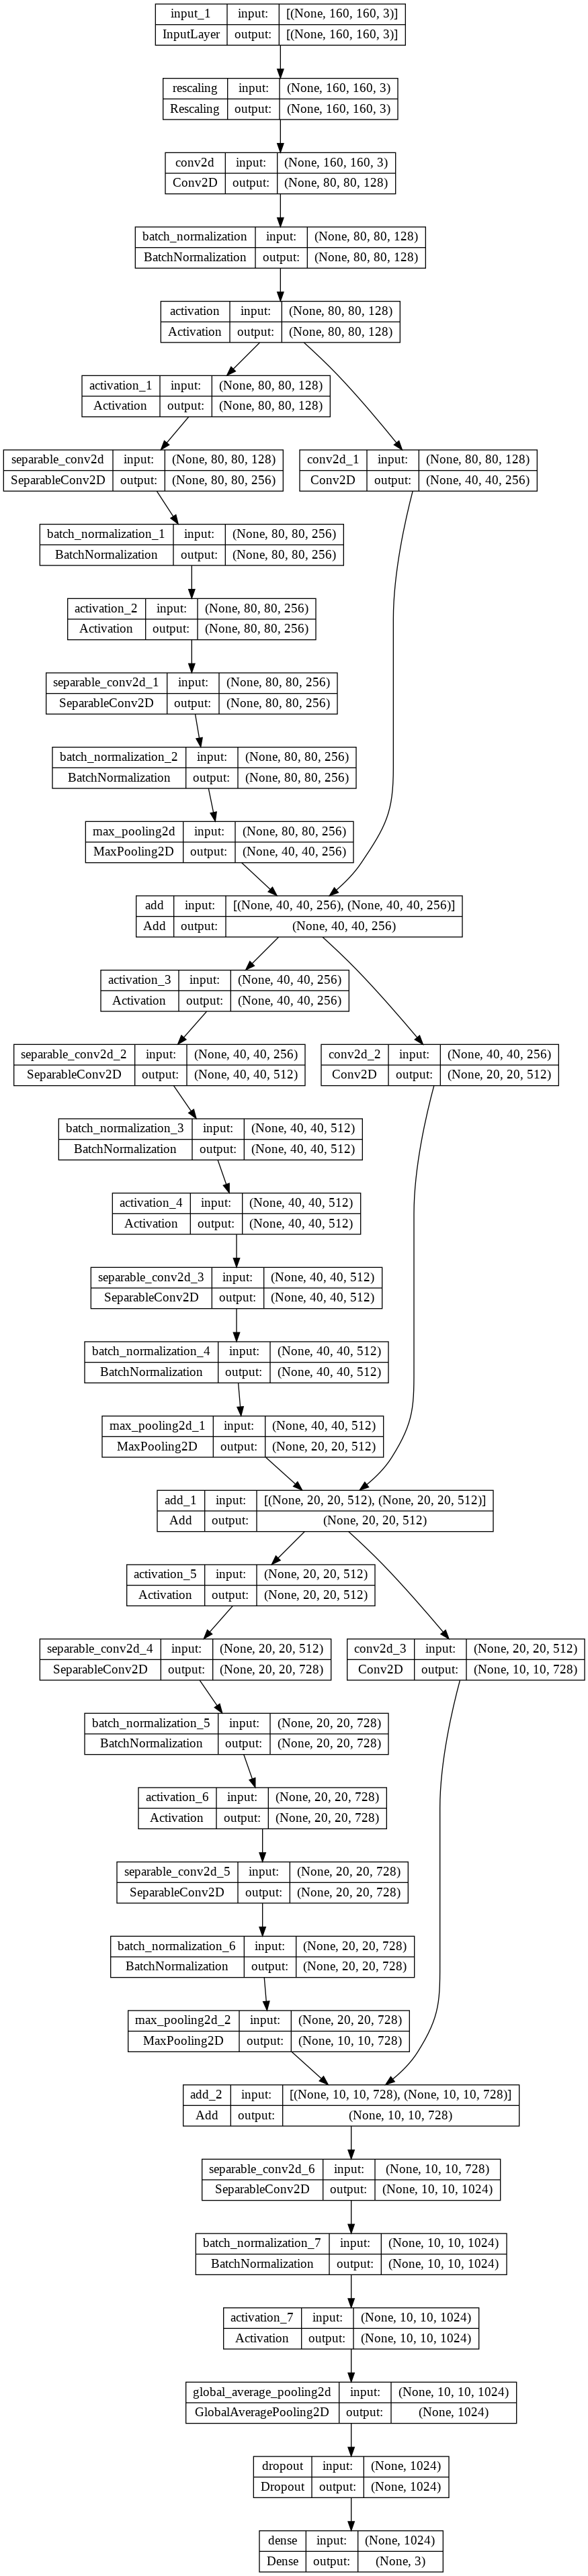

In [ ]:
# This is a simplified version of Xception
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Build the model using the functional API
num_classes=3

i = Input(shape=image_size)
x = Conv2D(32, (3,3), strides=2, activation='relu')(i)
x = Conv2D(64, (3,3), strides=2, activation='relu')(x)
x = Conv2D(128, (3,3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(i, x)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#!pip install -q -U keras-tuner
#import keras_tuner as kt

     |████████████████████████████████| 135 kB 7.3 MB/s 
     |████████████████████████████████| 1.6 MB 54.5 MB/s 


# Training the Model

In [ ]:
epochs = 40

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    #loss="binary_crossentropy", # Use this for binary classification
    #loss="SparseCategoricalCrossentropy", # Use this for multiclass classification
    loss="categorical_crossentropy", # Use this for multiclass classification
    metrics=["accuracy"],
)
r = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
76/76 [==============================] - 35s 325ms/step - loss: 0.3663 - accuracy: 0.8587 - val_loss: 1.0668 - val_accuracy: 0.4753
Epoch 2/25
76/76 [==============================] - 24s 305ms/step - loss: 0.2282 - accuracy: 0.9201 - val_loss: 1.0580 - val_accuracy: 0.4753
Epoch 3/25
76/76 [==============================] - 24s 313ms/step - loss: 0.2172 - accuracy: 0.9339 - val_loss: 1.0953 - val_accuracy: 0.4753
Epoch 4/25
76/76 [==============================] - 24s 313ms/step - loss: 0.1657 - accuracy: 0.9492 - val_loss: 1.1737 - val_accuracy: 0.4753
Epoch 5/25
76/76 [==============================] - 25s 318ms/step - loss: 0.1471 - accuracy: 0.9497 - val_loss: 1.3516 - val_accuracy: 0.4753
Epoch 6/25
76/76 [==============================] - 24s 306ms/step - loss: 0.1540 - accuracy: 0.9487 - val_loss: 1.5529 - val_accuracy: 0.4753
Epoch 7/25
76/76 [==============================] - 25s 317ms/step - loss: 0.1108 - accuracy: 0.9603 - val_loss: 1.7207 - val_accuracy: 0.4753

# Training Summary

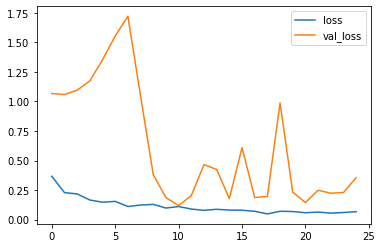

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

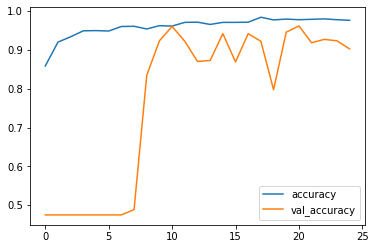

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

# Running the Model on "Real Data"

1/1 [==============================] - 0s 17ms/step
This image is:
 0.00% fire,
 2.79% safe,
 97.21% smoke.


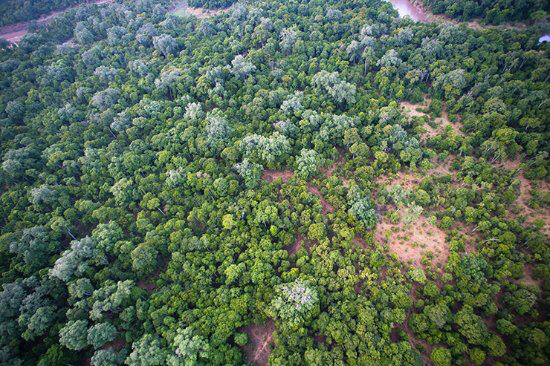

In [ ]:
im_path = "/content/forest-from-above.jpg"

img = keras.preprocessing.image.load_img(
    im_path, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
#score = float(predictions[0])

fire_score = float(predictions[0,0])
safe_score = float(predictions[0,1])
smoke_score = float(predictions[0,2])

print(f"This image is:\n {100 * fire_score:.2f}% fire,\n {100 * safe_score:.2f}% safe,\n {100 * smoke_score:.2f}% smoke.")
PIL.Image.open(str(im_path))

# Saving the Model

In [ ]:
model.save('model_v2_2.h5')

In [ ]:
!ls -lh

total 3.5G
drwxr-xr-x 4 root root 4.0K Dec 19 21:05 BigWildfireDataset
-rw-r--r-- 1 root root 322M Dec 19 21:05 BigWildfireDataset.zip
-rw-r--r-- 1 root root 339K Dec 19 21:05 model.png
-rw-r--r-- 1 root root  32M Dec 19 22:08 model_v2_2.h5
drwxr-xr-x 1 root root 4.0K Dec 16 21:15 sample_data
-rw-r--r-- 1 root root  32M Dec 19 22:04 save_at_100.keras
-rw-r--r-- 1 root root  32M Dec 19 21:12 save_at_10.keras
-rw-r--r-- 1 root root  32M Dec 19 21:12 save_at_11.keras
-rw-r--r-- 1 root root  32M Dec 19 21:13 save_at_12.keras
-rw-r--r-- 1 root root  32M Dec 19 21:14 save_at_13.keras
-rw-r--r-- 1 root root  32M Dec 19 21:14 save_at_14.keras
-rw-r--r-- 1 root root  32M Dec 19 21:15 save_at_15.keras
-rw-r--r-- 1 root root  32M Dec 19 21:15 save_at_16.keras
-rw-r--r-- 1 root root  32M Dec 19 21:16 save_at_17.keras
-rw-r--r-- 1 root root  32M Dec 19 21:16 save_at_18.keras
-rw-r--r-- 1 root root  32M Dec 19 21:17 save_at_19.keras
-rw-r--r-- 1 root root  32M Dec 19 21:07 save_at_1.keras
-rw-r--r--

#Loading the Model

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing import image
import PIL
import pathlib

In [2]:
!gdown --id 1Xr64W7i35oXnnuTWI6vvlrMpgkhmIVh- # Model_v2_1 image_size =160x160

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Xr64W7i35oXnnuTWI6vvlrMpgkhmIVh-
To: /content/model_v2_1.h5
100% 33.0M/33.0M [00:00<00:00, 39.3MB/s]


In [3]:
# Loading the data from Google Drive
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1WMX6Y1xp4pR-lImE3JaxMxswzge3Keu_ # Dataset
!unzip BigWildfireDataset.zip
!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WMX6Y1xp4pR-lImE3JaxMxswzge3Keu_
To: /content/BigWildfireDataset.zip
100% 324M/324M [00:06<00:00, 52.9MB/s]
Archive:  BigWildfireDataset.zip
   creating: BigWildfireDataset/test/
  inflating: BigWildfireDataset/test/test (1).jpg  
  inflating: BigWildfireDataset/test/test (10).jpg  
  inflating: BigWildfireDataset/test/test (100).jpg  
  inflating: BigWildfireDataset/test/test (101).jpg  
  inflating: BigWildfireDataset/test/test (102).jpg  
  inflating: BigWildfireDataset/test/te

In [4]:
model = tf.keras.models.load_model('model_v2_1.h5')

1/1 [==============================] - 1s 1s/step
This image is:
0.03% fire,
0.83% safe,
99.14% smoke.


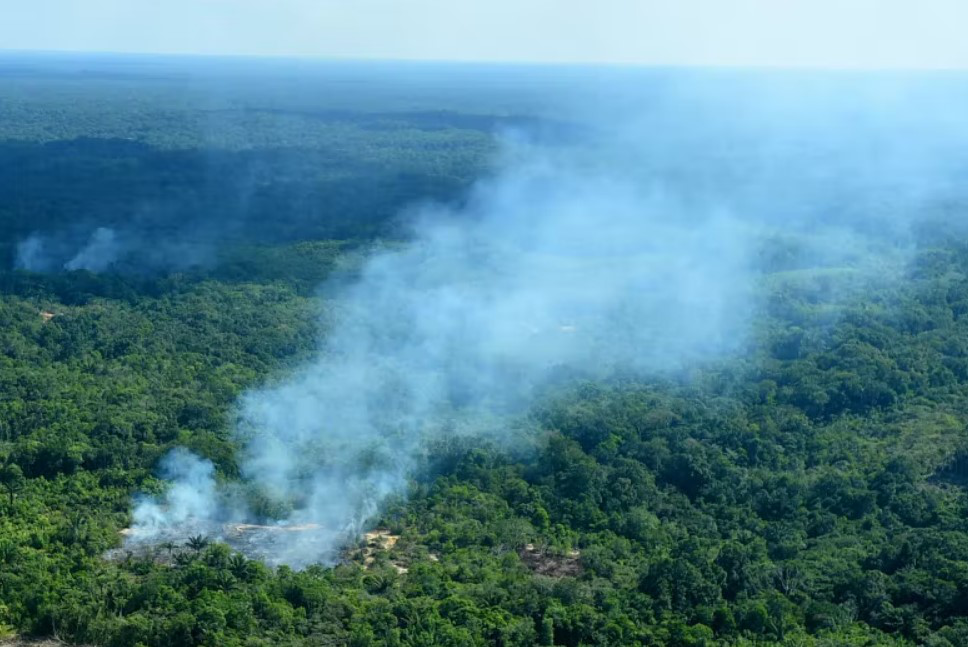

In [5]:
im_path = "/content/BigWildfireDataset/test/test (42).jpg"

image_size = (160, 160)

img = keras.preprocessing.image.load_img(
    im_path, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)

fire_score = float(predictions[0,0])
safe_score = float(predictions[0,1])
smoke_score = float(predictions[0,2])

print(f"This image is:\n{100 * fire_score:.2f}% fire,\n{100 * safe_score:.2f}% safe,\n{100 * smoke_score:.2f}% smoke.")
PIL.Image.open(str(im_path))

In [7]:
import os

dir_path = "/content/BigWildfireDataset/test"

im_count = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
image_size = (160, 160)

for x in range(im_count+1):
  img = keras.preprocessing.image.load_img(im_path, target_size=image_size)
  
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)

1/1 [==============================] - 0s 289ms/step


In [8]:
import os

dir_path = "/content/BigWildfireDataset/test"

im_count = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
image_size = (160, 160)
predictions = np.zeros((im_count,3))

for x in range(im_count):
  im_path = f"/content/BigWildfireDataset/test/test ({x+1}).jpg"

  img = keras.preprocessing.image.load_img(im_path, target_size=image_size)
  
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  prediction = model.predict(img_array)

  fire_score = float(prediction[0,0])
  safe_score = float(prediction[0,1])
  smoke_score = float(prediction[0,2])

  predictions[x,:] = [fire_score, safe_score, smoke_score]

1/1 [==============================] - 0s 113ms/step


In [ ]:
predictions

array([[9.99996901e-01, 1.97728764e-06, 1.02807644e-06],
       [9.99983191e-01, 1.45684880e-05, 2.27137662e-06],
       [9.85525191e-01, 4.96685132e-03, 9.50796716e-03],
       ...,
       [1.99078918e-02, 9.78997111e-01, 1.09499460e-03],
       [5.85195363e-01, 1.12952199e-04, 4.14691687e-01],
       [4.33468409e-02, 1.78925097e-01, 7.77728081e-01]])

In [9]:
for x in range(im_count):
  fire_score = float(predictions[x,0])
  safe_score = float(predictions[x,1])
  smoke_score = float(predictions[x,2])

  print(f"Image number {x+1} is:\n{100 * fire_score:.2f}% fire,\n{100 * safe_score:.2f}% safe,\n{100 * smoke_score:.2f}% smoke.")


Image number 1 is:
100.00% fire,
0.00% safe,
0.00% smoke.
Image number 2 is:
100.00% fire,
0.00% safe,
0.00% smoke.
Image number 3 is:
98.55% fire,
0.50% safe,
0.95% smoke.
Image number 4 is:
100.00% fire,
0.00% safe,
0.00% smoke.
Image number 5 is:
100.00% fire,
0.00% safe,
0.00% smoke.
Image number 6 is:
99.96% fire,
0.00% safe,
0.03% smoke.
Image number 7 is:
100.00% fire,
0.00% safe,
0.00% smoke.
Image number 8 is:
96.05% fire,
3.94% safe,
0.01% smoke.
Image number 9 is:
97.46% fire,
2.54% safe,
0.00% smoke.
Image number 10 is:
100.00% fire,
0.00% safe,
0.00% smoke.
Image number 11 is:
60.54% fire,
15.17% safe,
24.29% smoke.
Image number 12 is:
99.60% fire,
0.37% safe,
0.03% smoke.
Image number 13 is:
100.00% fire,
0.00% safe,
0.00% smoke.
Image number 14 is:
99.77% fire,
0.19% safe,
0.04% smoke.
Image number 15 is:
100.00% fire,
0.00% safe,
0.00% smoke.
Image number 16 is:
100.00% fire,
0.00% safe,
0.00% smoke.
Image number 17 is:
99.99% fire,
0.00% safe,
0.00% smoke.
Image number